In [311]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sn
import requests
import statsmodels.tsa.stattools as sm
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.rolling import RollingOLS
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup

In [ ]:
def getTickers(industry):
    url = f"https://finance.yahoo.com/sectors/{industry.lower()}/"
    webData = requests.get(url)
    soup = BeautifulSoup(webData.content,'html.parser')
    rows = soup.find_all('span',class_="symbol yf-ravs5v")
    ticker = []
    for row in rows: 
       ticker.append(row.text)
    return ticker[:10]

In [313]:
industry = "technology"
tickers = getTickers(industry)
tickers

['AAPL', 'NVDA', 'MSFT', 'AVGO', 'ORCL', 'CRM', 'AMD', 'ADBE', 'ACN', 'CSCO']

In [314]:
histData = yf.download(tickers,start='2020-01-01',end='2023-12-31')
prices = pd.DataFrame(histData['Adj Close'])
prices

[*********************100%%**********************]  10 of 10 completed


Ticker,AAPL,ACN,ADBE,AMD,AVGO,CRM,CSCO,MSFT,NVDA,ORCL
Date,,,,,,,,,,
2020-01-02,72.876122,196.058380,334.429993,49.099998,28.153460,166.512955,42.057178,153.938202,5.973633,50.055779
2020-01-03,72.167603,195.731857,331.809998,48.599998,27.437376,165.695297,41.370995,152.021408,5.878019,49.879486
2020-01-06,72.742653,194.453705,333.709991,48.389999,27.396332,172.954498,41.518650,152.414352,5.902669,50.139278
2020-01-07,72.400558,190.255463,333.390015,48.250000,27.302019,175.497223,41.249378,151.024612,5.974131,50.250622
2020-01-08,73.565193,190.628647,337.869995,47.830002,26.961443,176.823425,41.275448,153.430252,5.985336,50.446323
...,...,...,...,...,...,...,...,...,...,...
2023-12-22,192.868149,350.262146,598.750000,139.600006,111.368576,265.579132,48.881687,372.543945,48.823704,105.152885
2023-12-26,192.320221,349.254181,598.260010,143.410004,112.352257,265.459503,49.067101,372.623505,49.272640,105.142990
2023-12-27,192.419830,349.639587,596.080017,146.070007,111.784477,265.958038,49.223240,372.036713,49.410622,104.895462


<Axes: xlabel='Ticker', ylabel='Ticker'>

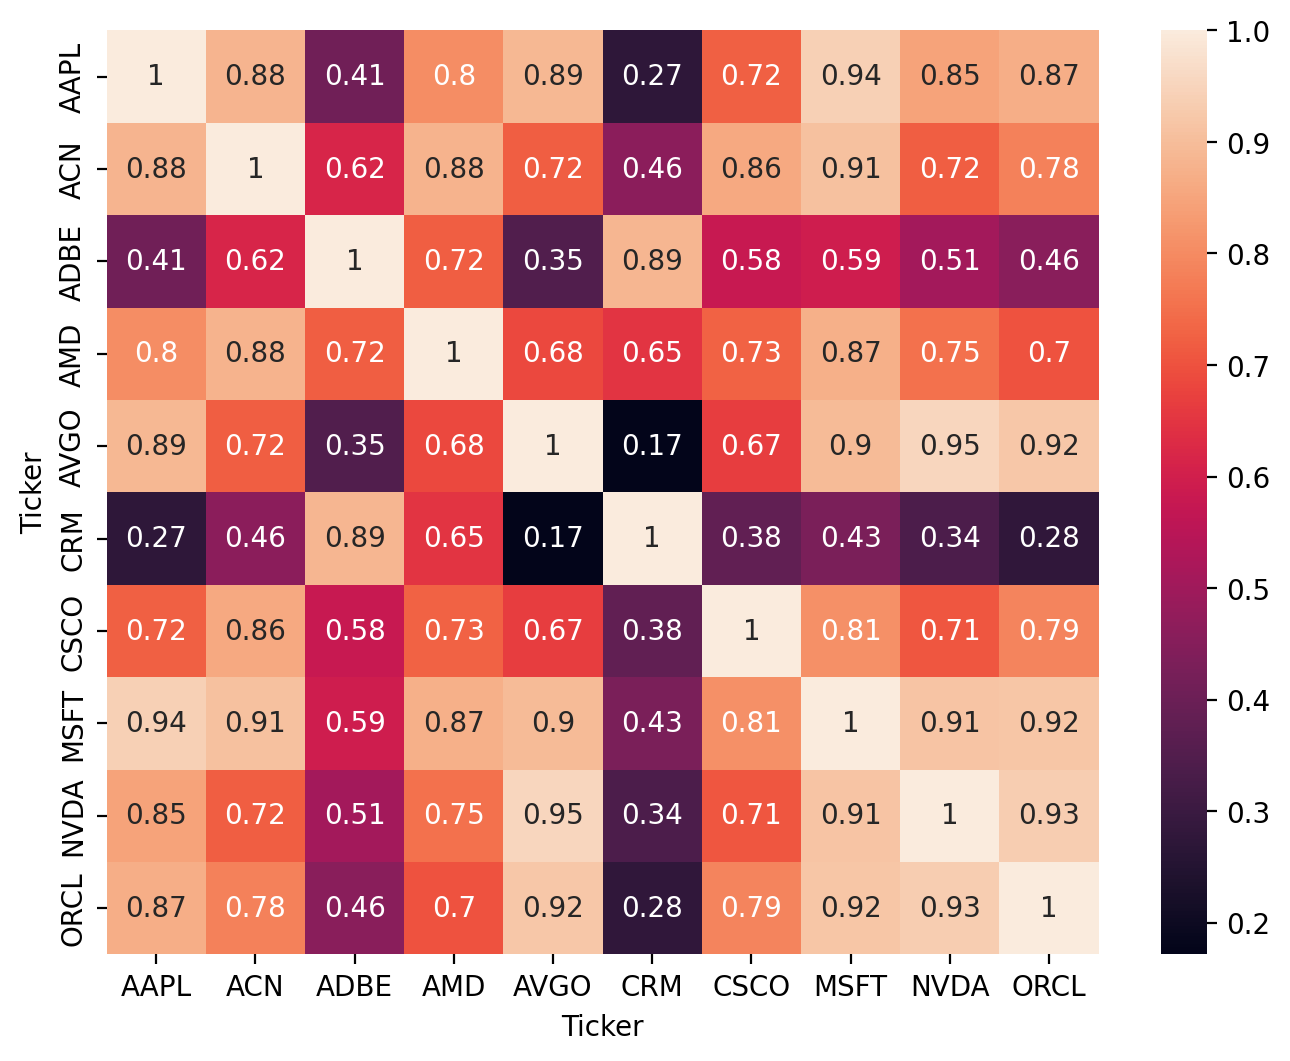

In [315]:
corMtrx = prices.corr()
figure(figsize=(8,6), dpi=200)
sn.heatmap(corMtrx,annot=True)

In [316]:
np.fill_diagonal(corMtrx.values, np.nan)
Value,Pair = [],[]
mtrx = corMtrx.copy()
for i in range(10):  
        mxValue = mtrx.max().max()
        mxPair = mtrx.stack().idxmax()
        Value.append(mxValue)
        Pair.append(mxPair)
        print(Pair[i],"-->",Value[i])
        mtrx[mxPair[0]][mxPair[1]] = np.nan
        mtrx[mxPair[1]][mxPair[0]] = np.nan

('AVGO', 'NVDA') --> 0.9541257316947023
('AAPL', 'MSFT') --> 0.9392217991518419
('NVDA', 'ORCL') --> 0.9335414057919705
('AVGO', 'ORCL') --> 0.9206358780320179
('MSFT', 'ORCL') --> 0.9175555275515844
('MSFT', 'NVDA') --> 0.914212120399153
('ACN', 'MSFT') --> 0.9088215439946852
('AVGO', 'MSFT') --> 0.8955421701473985
('AAPL', 'AVGO') --> 0.8883600739552932
('ADBE', 'CRM') --> 0.8853262010296363


In [317]:
pairCheck = Pair.copy()
ciPair = []
print("A p-Value less than 0.05 indicates there exists a cointegration between the two stock prices")
for i in pairCheck:
        a = prices[i[0]]
        b = prices[i[1]]
        ci = sm.coint(a,b)
        p_Value = ci[1]
        print(i,":",p_Value)
        if p_Value < 0.05:
            ciPair.append(i)           
stock1,stock2 = ciPair[0][0],ciPair[0][1]

A p-Value less than 0.05 indicates there exists a cointegration between the two stock prices
('AVGO', 'NVDA') : 0.6770940559065491
('AAPL', 'MSFT') : 0.22061716391155556
('NVDA', 'ORCL') : 0.20287398683790353
('AVGO', 'ORCL') : 0.9062029710853716
('MSFT', 'ORCL') : 0.08436706181799158
('MSFT', 'NVDA') : 0.47879949762307694
('ACN', 'MSFT') : 0.21636424999173692
('AVGO', 'MSFT') : 0.7078197958570553
('AAPL', 'AVGO') : 0.5503521188205353
('ADBE', 'CRM') : 0.027607382216079647


In [318]:
a,b = prices[stock1],prices[stock2]
a = sm.add_constant(a)
reg = sm.OLS(b,a).fit()
reg.params

const    46.426780
ADBE      0.348652
dtype: float64

In [319]:
alpha = reg.params.values[0]
beta = reg.params.values[1]
res = b-(alpha+a[stock1]*beta)
res

Date
2020-01-02     3.486500
2020-01-03     3.582309
2020-01-06    10.179074
2020-01-07    12.833359
2020-01-08    12.597607
                ...    
2023-12-22    10.396988
2023-12-26    10.448195
2023-12-27    11.706789
2023-12-28    10.765284
2023-12-29     7.955741
Length: 1006, dtype: float64

Text(0, 0.5, 'Values')

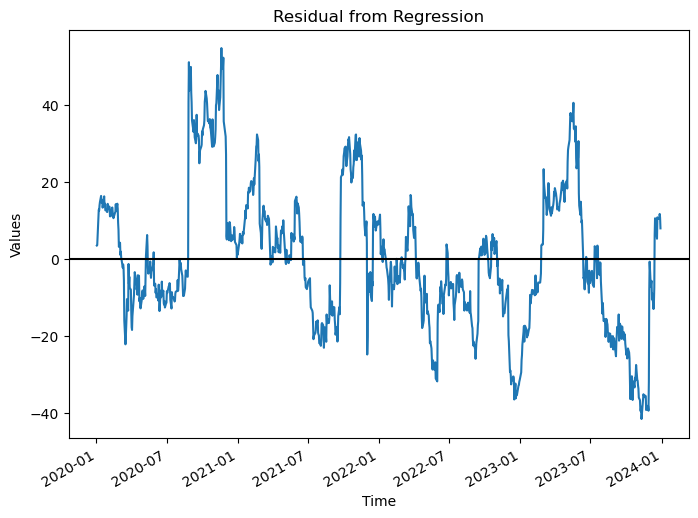

In [320]:
figure(figsize=(8,6), dpi=100)
res.plot()
plt.title("Residual from Regression")
plt.axhline(res.mean(),color='black')
plt.xlabel("Time")
plt.ylabel("Values")

In [321]:
adf = adfuller(res,maxlag=1)
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print('Critical Values:')
for i, j in adf[4].items():
    print(f"{i}: {j}")

ADF Statistic: -3.6028002648415223
p-value: 0.005707717813641836
Critical Values:
1%: -3.436879978012783
5%: -2.86442302475405
10%: -2.568305057578451


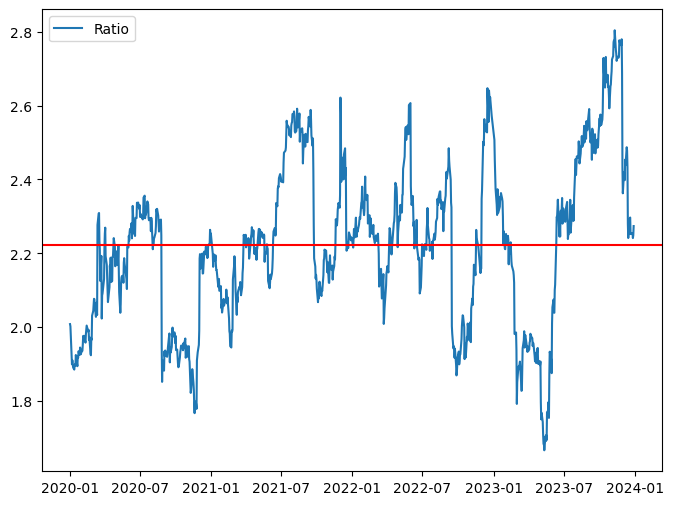

In [322]:
figure(figsize=(8,6), dpi=100)
ratio = prices[stock1]/prices[stock2]
plt.plot(ratio,label='Ratio')
plt.axhline(ratio.mean(),color='red')
plt.legend()

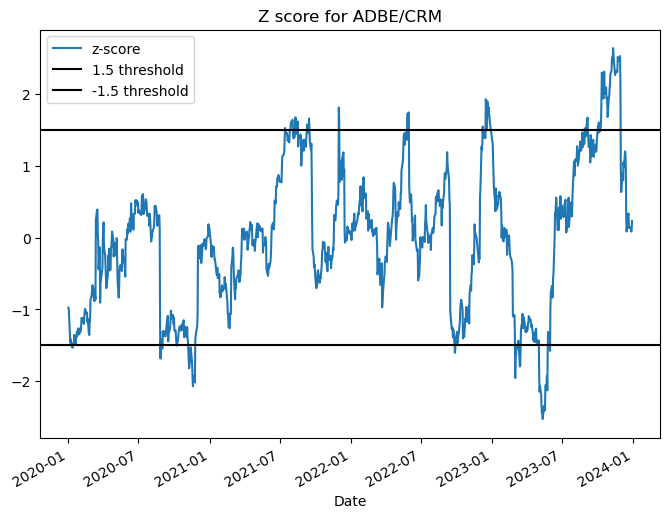

In [324]:
figure(figsize=(8,6), dpi=100)
zsc = (ratio-ratio.mean())/ratio.std()
zsc.plot(label='z-score')
plt.title(f"Z score for {stock1}/{stock2}")
plt.axhline(1.5,color='black',label='1.5 threshold')
plt.axhline(-1.5,color='black',label='-1.5 threshold')
plt.legend()

Text(0.5, 1.0, 'Ratio of CRM-ADBE')

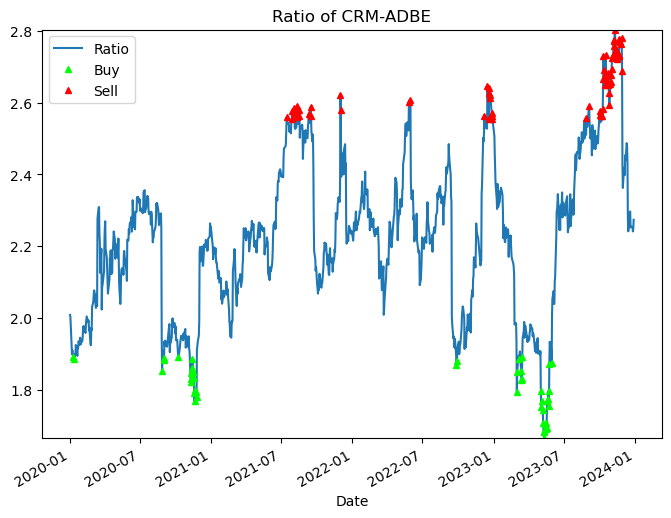

In [325]:
figure(figsize=(8,6), dpi=100)
ratio.plot()
long = ratio.copy()
short = ratio.copy()
long[zsc>-1.5] = 0
short[zsc<1.5] = 0
long.plot(color='lime',linestyle='None',marker='^',markersize=5)
short.plot(color='red',linestyle='None',marker='^',markersize=5)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,spread.min(),spread.max()))
plt.legend(["Ratio","Buy","Sell"])
plt.title(f"Ratio of {stock2}-{stock1}")

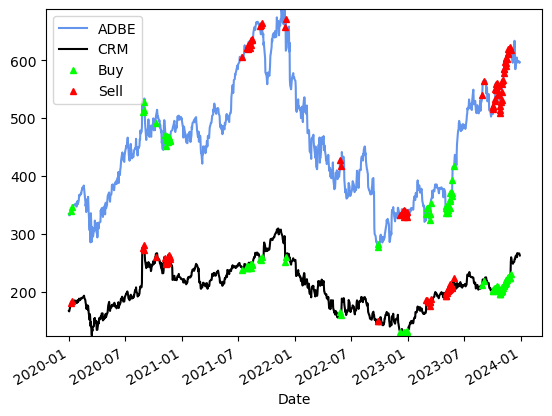

In [326]:
stock1_prices = prices[stock1]
stock2_prices = prices[stock2]
stock1_prices.plot(color='cornflowerblue',label=stock1)
stock2_prices.plot(color='black',label=stock2)

buy = 0*stock1_prices.copy()
sell = 0*stock1_prices.copy()

buy[long!=0] = stock1_prices[long!=0]
sell[long!=0] = stock2_prices[long!=0]
buy[short!=0] = stock2_prices[short!=0]
sell[short!=0] = stock1_prices[short!=0]

buy.plot(color='lime',linestyle='None',marker='^',markersize=5)
sell.plot(color='red',linestyle='None',marker='^',markersize=5)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1, x2, min(stock1_prices.min(),stock2_prices.min()),max(stock1_prices.max(),stock2_prices.max())))
plt.legend([stock1,stock2,"Buy","Sell"])

In [327]:
test = pd.DataFrame()
test[stock1] = prices[stock1]
test[stock2] = prices[stock2]

test["Long Entry"] = ((zsc<-1.5) & (zsc.shift(1)>-1.5)).astype(int)
test["Long Exit"] = ((zsc>0) & (zsc.shift(1)<0)).astype(int)

test["Short Entry"] = ((zsc>1.5) & (zsc.shift(1)<1.5)).astype(int)
test["Short Exit"] = ((zsc<0) & (zsc.shift(1)>0)).astype(int)
test

,ADBE,CRM,Long Entry,Long Exit,Short Entry,Short Exit
Date,,,,,,
2020-01-02,334.429993,166.512955,0,0,0,0
2020-01-03,331.809998,165.695297,0,0,0,0
2020-01-06,333.709991,172.954498,0,0,0,0
2020-01-07,333.390015,175.497223,0,0,0,0
2020-01-08,337.869995,176.823425,0,0,0,0
...,...,...,...,...,...,...
2023-12-22,598.750000,265.579132,0,0,0,0
2023-12-26,598.260010,265.459503,0,0,0,0
2023-12-27,596.080017,265.958038,0,0,0,0


In [329]:
position = None;pnl = [];x=-1;y=0;
for i,j in test.iterrows():
    x=x+1
    s1,s2,l_entry,l_exit,s_entry,s_exit = j
    if position == None:
        s1_return = 0
        s2_return = 0
        pnl.append([i,s1_return,s2_return,position])
        
        if l_entry:
            position='Long'
        elif s_entry:
            position='Short'
    
    elif position == 'Long':
        s1_return = test[stock1][x]/test[stock1][x-1] -1
        s2_return = test[stock2][x]/test[stock2][x-1] -1
        pnl.append([i,s1_return,-s2_return,position])
        
        if l_exit:
            position=None
    
    elif position == 'Short':
        s1_return = test[stock1][x]/test[stock1][x-1] -1
        s2_return = test[stock2][x]/test[stock2][x-1] -1
        pnl.append([i,-s1_return,s2_return,position])
        
        if s_exit:
            position=None

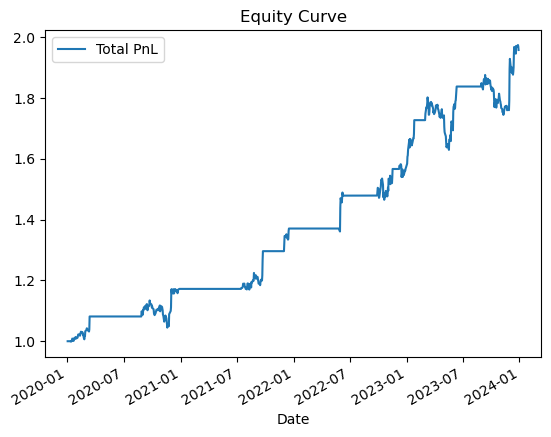

In [330]:
test_df = pd.DataFrame(pnl,columns=['Date',stock1,stock2,'Position'])
test_df['Stock1 PL'] = np.cumprod(test_df[stock1]+1)
test_df['Stock2 PL'] = np.cumprod(test_df[stock2]+1)
test_df['Total PL'] = (test_df['Stock1 PL']+test_df['Stock2 PL'])/2
test_df.index = test_df['Date']

test_df['Total PL'].plot(label='Total PnL')
plt.title('Equity Curve')
plt.legend()